Environment: tldm

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image

/home/taha/.conda/envs/tldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        """
        Args:
            img_folder (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_folder = img_folder
        self.transform = transform
        self.img_paths = [os.path.join(img_folder, fname) for fname in os.listdir(img_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)  # Read image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert image to float32 for safe addition
        img = img.astype(np.float32)

        # Randomly sample a standard deviation from the range [0, 200]
        std = np.random.uniform(0, 200)

        # Add Gaussian noise
        noise = np.random.normal(0, std, img.shape).astype(np.float32)  # Mean 0, random std
        noisy_img = img + noise

        # Clip values to [0, 255] and convert back to uint8
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

        if self.transform:
            img = self.transform(img.astype(np.uint8))  # Apply transform to original image
            noisy_img = self.transform(noisy_img)       # Apply transform to noisy image

        return img, noisy_img

In [3]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),   # Convert numpy array to PIL image
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),  # Convert image to Tensor
])

In [4]:
# Load datasets
train_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_preprocess/train", transform=transform)
val_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_preprocess/val", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Print dataset size
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 15000
Validation samples: 10000


In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 254x254x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 252x252x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 126x126x64

        # input: 126x126x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 124x124x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 122x122x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 61x61x128

        # input: 61x61x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 27x27x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 25x25x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 13x13x256

        # input: 13x13x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 11x11x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 9x9x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 5x5x512

        # input: 5x5x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 3x3x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 1x1x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=3)
model = model.to(device)
from torchsummary import summary
summary(model, input_size=(3, 256, 256), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 256, 256]           1,792
            Conv2d-2         [64, 64, 256, 256]          36,928
         MaxPool2d-3         [64, 64, 128, 128]               0
            Conv2d-4        [64, 128, 128, 128]          73,856
            Conv2d-5        [64, 128, 128, 128]         147,584
         MaxPool2d-6          [64, 128, 64, 64]               0
            Conv2d-7          [64, 256, 64, 64]         295,168
            Conv2d-8          [64, 256, 64, 64]         590,080
         MaxPool2d-9          [64, 256, 32, 32]               0
           Conv2d-10          [64, 512, 32, 32]       1,180,160
           Conv2d-11          [64, 512, 32, 32]       2,359,808
        MaxPool2d-12          [64, 512, 16, 16]               0
           Conv2d-13         [64, 1024, 16, 16]       4,719,616
           Conv2d-14         [64, 1024,

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 50

train_losses = []
val_losses = []

# Set up early stopping parameters
patience = 5  # Number of epochs with no improvement after which training will be stopped
best_loss = float('inf') #set to positive infinity to ensure that the first validation loss encountered will always be considered an improvement
counter = 0  # Counter to keep track of consecutive epochs with no improvement

#Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for train_clean_images, train_noisy_images in train_loader:
        train_clean_images, train_noisy_images = train_clean_images.to(device), train_noisy_images.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        train_outputs = model(train_noisy_images)
        # Find the Loss
        train_loss = criterion(train_outputs, train_clean_images)
        # Calculate gradients
        train_loss.backward()
        # Update Weights
        optimizer.step()

        # accumulate the training loss
        running_loss += train_loss.item()
            
    train_total_loss = running_loss / len(train_loader)
    train_losses.append(train_total_loss)

    #Validation
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for val_clean_images, val_noisy_images in val_loader:
            val_clean_images, val_noisy_images = val_clean_images.to(device), val_noisy_images.to(device)
            val_op = model(val_noisy_images)
            val_loss = criterion(val_op, val_clean_images)
            val_running_loss += val_loss.item()
        
        val_total_loss = val_running_loss / len(val_loader)
        val_losses.append(val_total_loss)

    # Check if validation loss has improved
    if val_total_loss < best_loss:
        best_loss = val_total_loss
        counter = 0
        # Save the model if needed
        torch.save(model.state_dict(), 'best_model_random_std.pth')

    else:
        counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_total_loss:.4f},  Validation Loss: {val_total_loss: .4f}, Best Loss: {best_loss: .4f}')

    sampled_noisy_image = train_noisy_images[0:1:,:,:,:]
    sampled_clean_image = train_clean_images[0:1:,:,:,]
    sampled_train_output = train_outputs[0:1:,:,:,:]
    save_image(sampled_noisy_image, 'trainnoisyimagebeforeunet.jpg')
    save_image(sampled_clean_image, 'traintargetcleanimage.jpg')
    save_image(sampled_train_output, 'traincleanimageafterunet.jpg')

Epoch 1/50, Training Loss: 0.0206,  Validation Loss:  0.0070, Best Loss:  0.0070
Epoch 2/50, Training Loss: 0.0062,  Validation Loss:  0.0054, Best Loss:  0.0054
Epoch 3/50, Training Loss: 0.0050,  Validation Loss:  0.0047, Best Loss:  0.0047
Epoch 4/50, Training Loss: 0.0046,  Validation Loss:  0.0043, Best Loss:  0.0043
Epoch 5/50, Training Loss: 0.0043,  Validation Loss:  0.0041, Best Loss:  0.0041
Epoch 6/50, Training Loss: 0.0042,  Validation Loss:  0.0039, Best Loss:  0.0039
Epoch 7/50, Training Loss: 0.0040,  Validation Loss:  0.0039, Best Loss:  0.0039
Epoch 8/50, Training Loss: 0.0038,  Validation Loss:  0.0037, Best Loss:  0.0037
Epoch 9/50, Training Loss: 0.0038,  Validation Loss:  0.0039, Best Loss:  0.0037
Epoch 10/50, Training Loss: 0.0038,  Validation Loss:  0.0038, Best Loss:  0.0037
Epoch 11/50, Training Loss: 0.0037,  Validation Loss:  0.0037, Best Loss:  0.0037
Epoch 12/50, Training Loss: 0.0036,  Validation Loss:  0.0035, Best Loss:  0.0035
Epoch 13/50, Training Los

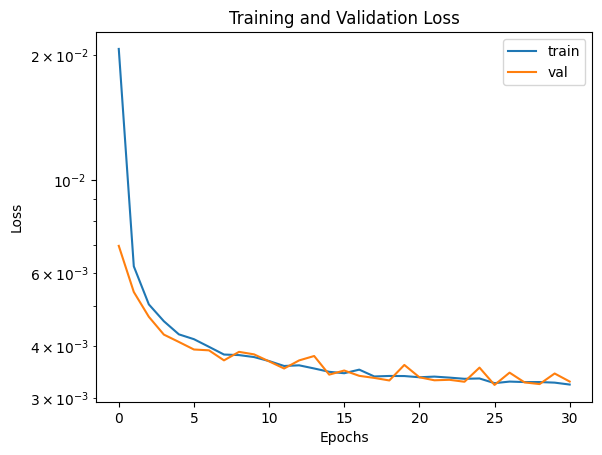

In [9]:
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
plt.show()

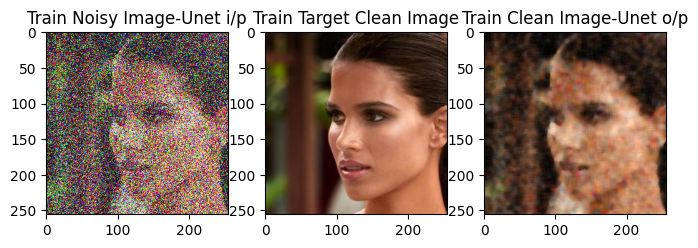

In [10]:
plt.figure(figsize=(8,8))
img1 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/training_random_std_0_200/trainnoisyimagebeforeunet.jpg")
img2 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/training_random_std_0_200/traintargetcleanimage.jpg")
img3 = mpimg.imread("/home/data/taha/UNET-denoising/clean_task_unet_denoising/training_random_std_0_200/traincleanimageafterunet.jpg")
plt.subplot(1,3,1).set_title("Train Noisy Image-Unet i/p")
plt.imshow(img1)
plt.subplot(1,3,2).set_title("Train Target Clean Image")
plt.imshow(img2)
plt.subplot(1,3,3).set_title("Train Clean Image-Unet o/p")
plt.imshow(img3)
plt.show()